<a href="https://colab.research.google.com/github/banshee0716/Financial-Big-Data-Analysis/blob/master/%E9%87%91%E8%9E%8D%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90W4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install yfinance pandas numpy matplotlib statsmodels scikit-learn

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
#warnings.filterwarnings("ignore", category=ValueWarning)

[*********************100%***********************]  1 of 1 completed


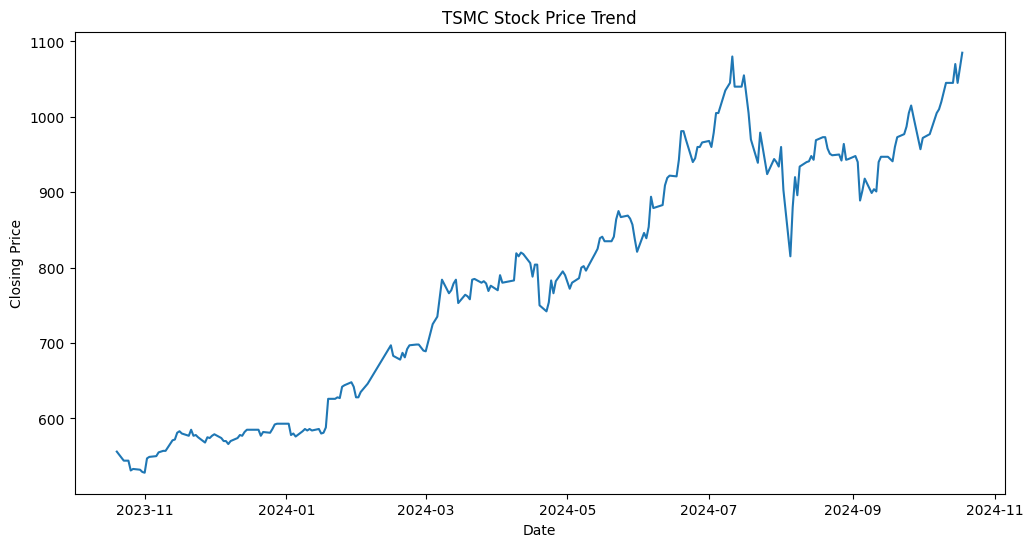

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# 下載台積電股票數據
stock_id = "2330.TW"
end = pd.Timestamp.now()
start = end - pd.Timedelta(days=365)
df = yf.download(stock_id, start=start, end=end)

df.head()


# 選擇收盤價作為預測目標
close_prices = df['Close']

# 2. Data Exploration and Visualization
plt.figure(figsize=(12,6))
plt.plot(close_prices)
plt.title('TSMC Stock Price Trend')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


In [ ]:
# 3. 檢查平穩性
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF 統計量：', result[0])
    print('p-value：', result[1])
    print('臨界值：', result[4])
    if result[1] <= 0.05:
        print("數據是平穩的")
    else:
        print("數據不是平穩的，需要進行差分")

print("原始數據的平穩性檢驗:")
test_stationarity(close_prices)

# 如果數據不平穩，進行差分
close_prices_diff = close_prices.diff().dropna()
print("\n一階差分後的平穩性檢驗:")
test_stationarity(close_prices_diff)

原始數據的平穩性檢驗:
ADF 統計量： -0.3999295650557798
p-value： 0.9101105368132807
臨界值： {'1%': -3.4582467982399105, '5%': -2.8738137461081323, '10%': -2.5733111490323846}
數據不是平穩的，需要進行差分

一階差分後的平穩性檢驗:
ADF 統計量： -8.867167165579005
p-value： 1.4300604108141573e-14
臨界值： {'1%': -3.4582467982399105, '5%': -2.8738137461081323, '10%': -2.5733111490323846}
數據是平穩的


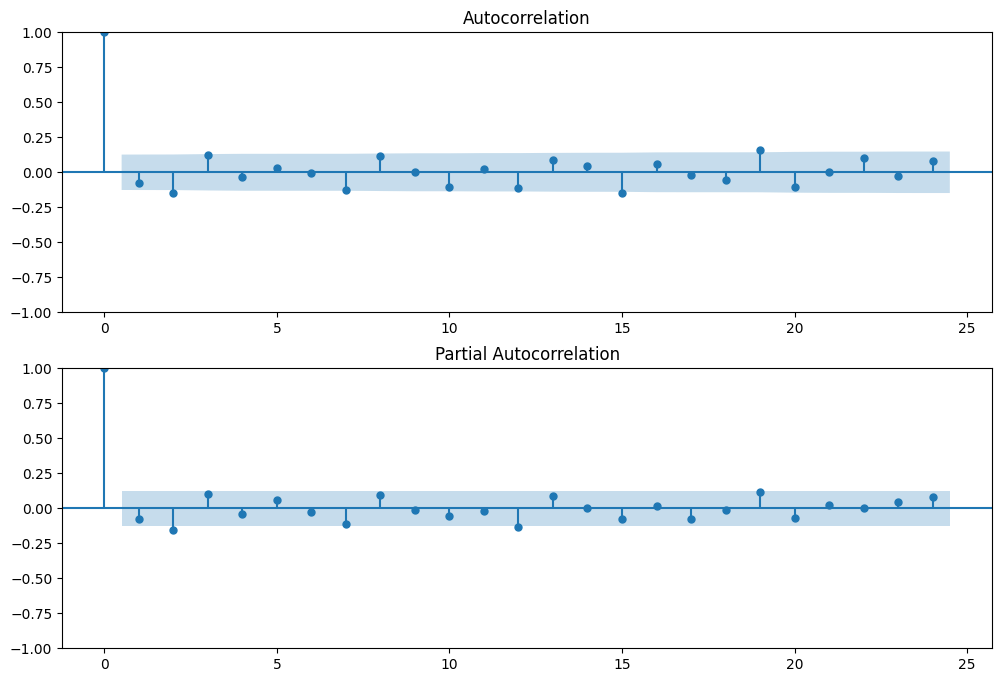

In [ ]:
# 4. 確定模型階數
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8))
plot_acf(close_prices_diff, ax=ax1)
plot_pacf(close_prices_diff, ax=ax2)
plt.show()

# 拆分數據為訓練集和測試集
train_size = int(len(close_prices) * 0.8)
train, test = close_prices[:train_size], close_prices[train_size:]

In [ ]:
def optimize_arima(train, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                try:
                    model = ARIMA(train, order=(p, d, q))
                    results = model.fit()
                    aic = results.aic
                    if aic < best_score:
                        best_score, best_cfg = aic, (p, d, q)
                except:
                    continue
    return best_cfg

# 設定參數範圍
p_values = range(0, 5)
d_values = range(0, 2)
q_values = range(0, 5)

# 找出最佳參數
best_cfg = optimize_arima(train, p_values, d_values, q_values)
print(f'\n最佳ARIMA參數: {best_cfg}')

# 使用最佳參數訓練ARIMA模型
model = ARIMA(train, order=best_cfg)
results = model.fit()
print(results.summary())


最佳ARIMA參數: (2, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  192
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -799.740
Date:                Sat, 19 Oct 2024   AIC                           1609.481
Time:                        06:16:04   BIC                           1625.742
Sample:                             0   HQIC                          1616.067
                                - 192                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4058      0.032    -44.280      0.000      -1.468      -1.344
ar.L2         -0.9677      0.024    -39.610      0.000      -1.016      -0.920
ma.L1          1.4438      0.0


MSE: 20181.025032326786
RMSE: 142.05993464846725
MAE: 134.2707360656243


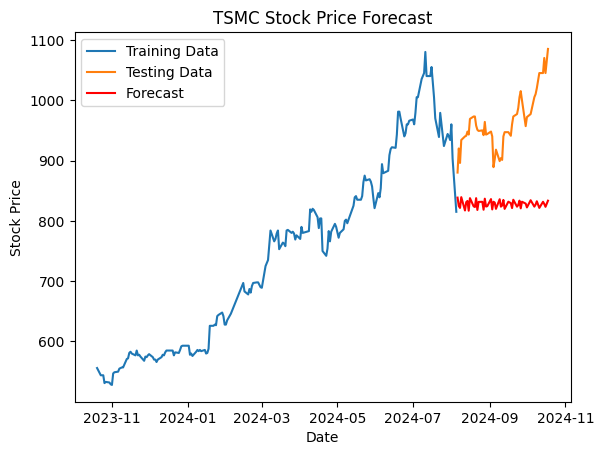

In [ ]:
forecast = results.forecast(steps=len(test))
mse = mean_squared_error(test, forecast)
rmse = sqrt(mse)
mae = mean_absolute_error(test, forecast)

print(f'\nMSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# 可視化結果plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.title('TSMC Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


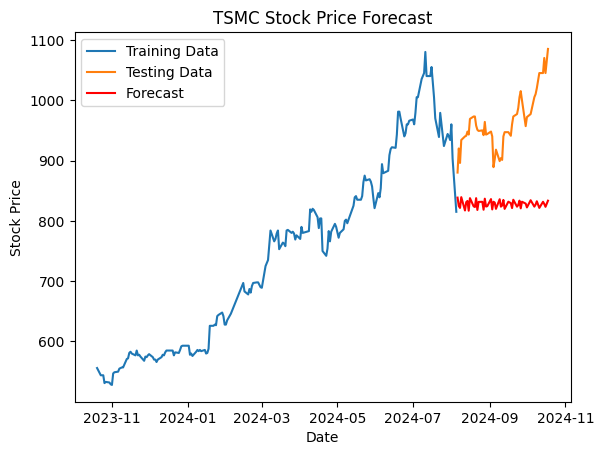

In [ ]:
# 可視化結果plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Testing Data')
plt.plot(test.index, forecast, color='red', label='Forecast')
plt.title('TSMC Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Stock Price Forecast for the Next 5 Days:
192    838.494962
193    824.522881
194    821.429206
195    839.298808
196    817.171416
Name: predicted_mean, dtype: float64


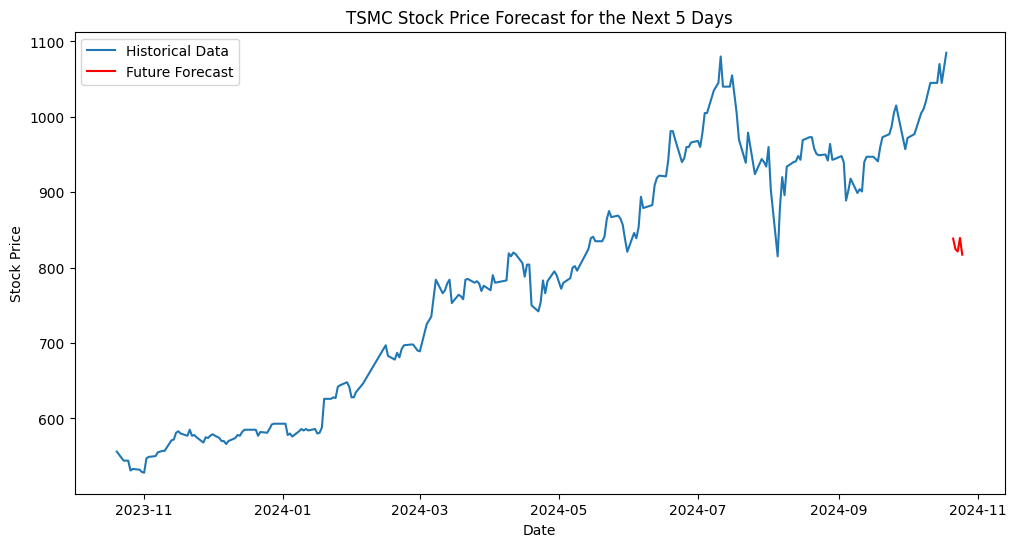

In [ ]:
# 預測未來5天的股價
future_forecast = results.forecast(steps=5)
print("\nStock Price Forecast for the Next 5 Days:")
print(future_forecast)

# Visualizing Future Forecast
plt.figure(figsize=(12,6))
plt.plot(close_prices.index, close_prices, label='Historical Data')
future_dates = pd.date_range(start=close_prices.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')
plt.plot(future_dates, future_forecast, color='red', label='Future Forecast')
plt.title('TSMC Stock Price Forecast for the Next 5 Days')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
